In [8]:
import efficientnet.tfkeras as efn  # Convolutional Neural Network architecture
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from efficientnet.keras import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
SOUND_DIR='/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/aldfly/XC16964.mp3'

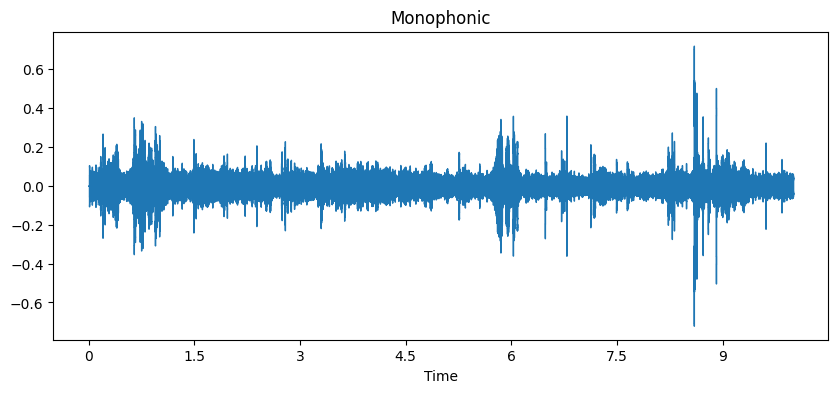

In [12]:
ipd.display(ipd.Audio(SOUND_DIR))

# load the mp3 file
signal, sr = librosa.load(SOUND_DIR, duration=10)  # sr = sampling rate

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Monophonic")
plt.show()

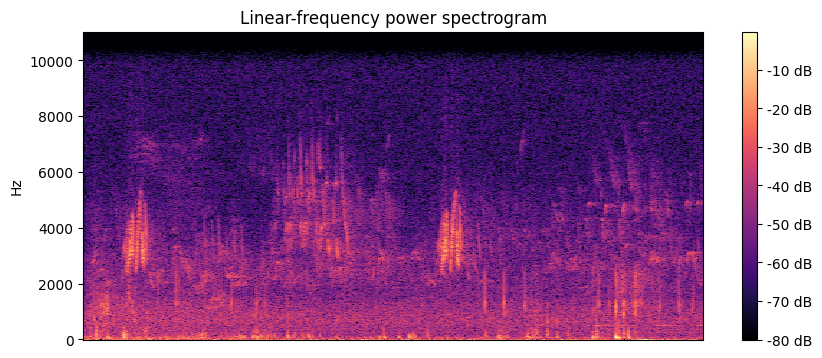

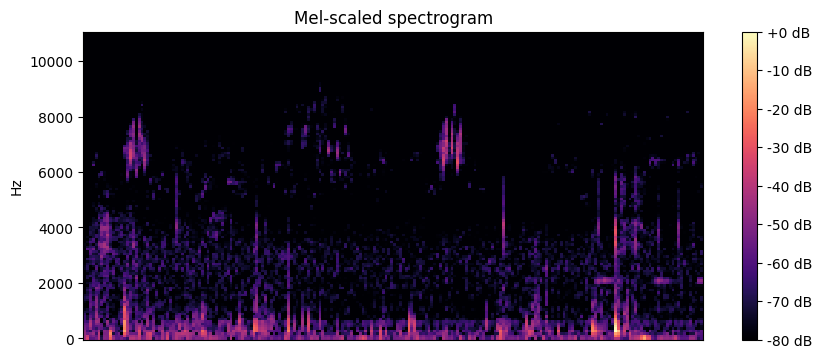

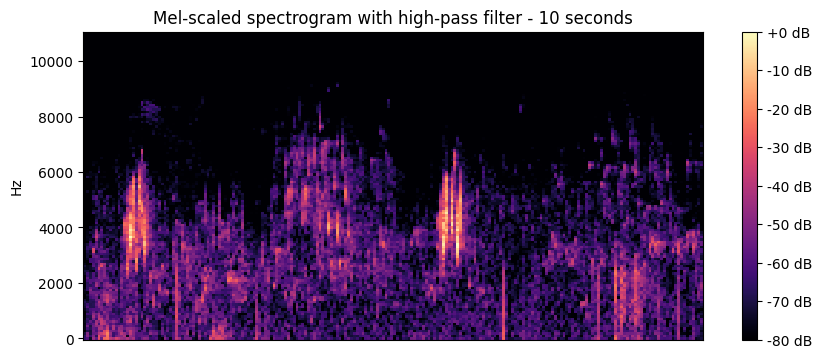

In [14]:
# Plot spectogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.title("Linear-frequency power spectrogram")
plt.show()

# Plot mel-spectrogram
N_FFT = 1024
HOP_SIZE = 1024
N_MELS = 128
WIN_SIZE = 1024
WINDOW_TYPE = "hann"
FEATURE = "mel"
FMIN = 0

S = librosa.feature.melspectrogram(
    y=signal,
    sr=sr,
    n_fft=N_FFT,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    htk=True,
    fmin=FMIN,
    fmax=sr / 2,
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(S ** 2, ref=np.max), fmin=FMIN, y_axis="linear"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-scaled spectrogram")
plt.show()

# Plot mel-spectrogram with high-pass filter
N_FFT = 1024
HOP_SIZE = 1024
N_MELS = 128
WIN_SIZE = 1024
WINDOW_TYPE = "hann"
FEATURE = "mel"
FMIN = 1400

S = librosa.feature.melspectrogram(
    y=signal,
    sr=sr,
    n_fft=N_FFT,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    htk=True,
    fmin=FMIN,
    fmax=sr / 2,
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(S ** 2, ref=np.max), fmin=FMIN, y_axis="linear"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-scaled spectrogram with high-pass filter - 10 seconds")
plt.show()

In [15]:
import os
birds = []
DATASET_URL = './data/mels-19class2/'
for root, dirs, files in os.walk(DATASET_URL):
    if root == DATASET_URL:
        birds = dirs

In [16]:
birds

['1amecr', '2amegf', '4amero', '3amere', '0aldfl']

In [70]:
IM_SIZE = (224,224) 
BIRDS = ['0amecr', '1amegf', '2amere', '3aldfl']
DATA_PATH = './data/19_class2/'
BATCH_SIZE = 16

In [71]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATA_PATH+'train',classes=BIRDS, target_size=IM_SIZE, class_mode='categorical', shuffle=True,batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATA_PATH+'val',classes=BIRDS,target_size=IM_SIZE, class_mode='categorical', shuffle=False, batch_size=BATCH_SIZE)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATA_PATH+'test', classes=BIRDS,target_size=IM_SIZE,class_mode='categorical', shuffle=False,batch_size=BATCH_SIZE)

Found 1856 images belonging to 4 classes.
Found 143 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [73]:
net = efn.EfficientNetB3(
    include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE
)
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(BIRDS), activation="softmax", name="softmax")(x)
net_final = Model(inputs=net.input, outputs=output_layer)
net_final.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

ValueError: `input_shape` must be a tuple of three integers.

In [55]:
# Estimate class weights for unbalanced dataset
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(train_batches.classes), y=train_batches.classes
)

# Define callbacks
ModelCheck = ModelCheckpoint(
    "./models/efficientnet_checkpoint.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    period=1,
)

ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=3e-4)

In [62]:
train_batches.directory

'./data/19_class2/train'

In [56]:
# Train the model
net_final.fit(
    train_batches_4,
    validation_data=valid_batches,
    epochs=30,
    steps_per_epoch=1596,
    class_weight=class_weights,
    callbacks=[ModelCheck, ReduceLR],
)

ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224,3,3)